# Определение возраста покупателей
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# загрузка данных
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
# основная информация о датасете labels
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
# размер датасете labels
labels.shape

(7591, 2)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Частота')

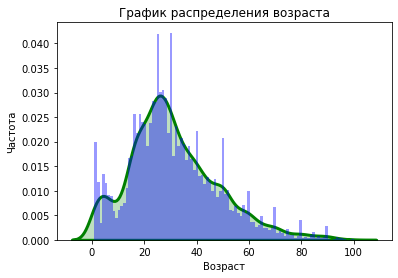

In [5]:
# построение графика распределения возраста в выборке labels
sns.distplot(labels['real_age'], hist = True, bins = 100, kde = True,
             kde_kws = {'color':'green','shade': True, 'linewidth': 3},
             hist_kws = {'color':'blue'});
plt.title('График распределения возраста')
plt.xlabel('Возраст')
plt.ylabel('Частота')

In [6]:
# извлечение данных
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    # папка, в которой хранится датасет
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    # размер изображения
    target_size=(150, 150), 
    # размер батча
    batch_size=16,
    # в каком виде выдавать метки классов
    class_mode='raw',
    # фиксируем генератор случайных чисел
    seed=12345) 

Found 7591 validated image filenames.


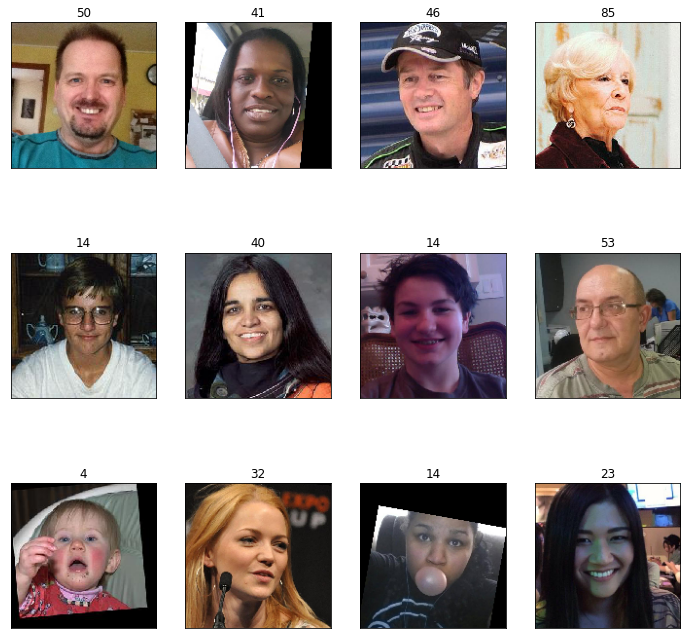

In [7]:
# вывод 10 изображений из датасета
x, y = next(datagen_flow)
fig = plt.figure(figsize = (12,12))
for i in range(12):
    fig.add_subplot(3,4, i+1)
    plt.imshow(x[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(y[i]);

**Вывод:** Всего в датасете 7591 фотография. По данным исследовательского анализа можно сказать, что в выборке большая часть фотографий людей в возрасте от 15 до 35 лет. Также на графике распределения наблюдаются пики в возрастах 40, 50, 60 и 80 лет. Фотографии разных размеров, некоторые фотографии черно-белые и некоторые из них расположены под углом. Также на некоторых фотографиях расположены посторонние предметы, которые закрывают лицо (рука, микррофон), что может повлиять на обучение. 

## Обучение модели

**Код модели:**

```python
# объявление библиотек
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
import numpy as np

# объявление функции load_train
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255,
                                 rotation_range = 40,
                                 width_shift_range = 30,
                                 height_shift_range = 30,
                                 horizontal_flip = True)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_gen_flow

# объявление функции load_test
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow

# объявление функции create_model
def create_model(input_shape):
    
    optimizer = Adam(learning_rate=0.0001)
 
    backbone = ResNet50(input_shape=input_shape, 
                        include_top=False, 
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error',
                  metrics=['mae'])
 
 
    return model

# объявление функции train_model
def train_model(model,
                train_data,
                test_data,
                batch_size=None,
                epochs=10,
                steps_per_epoch=None,
                validation_steps=None):
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model
```

**Результат обучения и значение метрики MAE:**

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 132s - loss: 270.8885 - mae: 11.9576 - val_loss: 884.4158 - val_mae: 24.8865
Epoch 2/10
178/178 - 118s - loss: 108.9884 - mae: 7.8931 - val_loss: 888.6024 - val_mae: 24.8980
Epoch 3/10
178/178 - 118s - loss: 92.0209 - mae: 7.2319 - val_loss: 315.1477 - val_mae: 13.0932
Epoch 4/10
178/178 - 117s - loss: 79.7095 - mae: 6.7547 - val_loss: 178.9090 - val_mae: 10.0283
Epoch 5/10
178/178 - 119s - loss: 65.6708 - mae: 6.2032 - val_loss: 89.0606 - val_mae: 7.1271
Epoch 6/10
178/178 - 121s - loss: 57.5318 - mae: 5.8153 - val_loss: 93.5539 - val_mae: 7.0136
Epoch 7/10
178/178 - 122s - loss: 53.4377 - mae: 5.6105 - val_loss: 82.8646 - val_mae: 7.1261
Epoch 8/10
178/178 - 115s - loss: 47.2045 - mae: 5.2778 - val_loss: 97.9810 - val_mae: 7.2045
Epoch 9/10
178/178 - 111s - loss: 44.8962 - mae: 5.0855 - val_loss: 80.3295 - val_mae: 6.6351
Epoch 10/10
178/178 - 109s - loss: 40.3201 - mae: 4.8853 - val_loss: 72.4319 - val_mae: 6.2741

60/60 - 11s - loss: 72.4319 - mae: 6.2741
```

## Анализ обученной модели

Модель сверточной нейронной сети построена на ResNet50.

За 10 эпох обучения удалось уменьшить MAE с 24.9 до 6.3 на тестовой выборке.

## Вывод

На первом этапе были загружены и исследованы данные. Датасет labels состоит из двух столбцов с наименованием фотографий и возрастом. Всего в датасете 7591 фотография. По данным исследовательского анализа можно сказать, что в выборке большая часть фотографий людей в возрасте от 15 до 35 лет. Фотографии разных размеров и некоторые из них расположены под углом. На некоторых фотографиях расположены посторонние предметы, которые закрывают лицо (рука, микррофон), что может повлиять на обучение.
На втором этапе была обучена модель. Модель сверточной нейронной сети построена на ResNet50. В результате обучения было получено необходимое значение метрики MAE, равное 6.3 на тестовой выборке. Данный результат был получен за 10 эпох.\
Результат можно улучшить, добавив дополнительные слои, но много слоев может привести к переобучению модели. Также для улучшения можно изменить значение batch_size или epochs.